<a href="https://colab.research.google.com/github/KrisMatrix/TensorFlow_Certification_Prep/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food 101 paper with 10% of the training (leveraging the power of Deep Learning).

**Link:** https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Wed Aug 18 19:00:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    63W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-18 19:00:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-18 19:00:59 (78.5 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb 

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-08-18 19:01:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.3’

101_food_classes_10 100%[===================>]   1.51G   182MB/s    in 8.6s    

2021-08-18 19:01:11 (180 MB/s) - ‘101_food_classes_10_percent.zip.3’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [7]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/guacamole'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_clas

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backend-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch)

In [9]:
# Create checkpoint callback

checkpoint_path = "101_classes_10_percent_data_model_"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [10]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  #preprocessing.RandomFlip("horizontal"),                                
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  #preprocessing.Rescaling(1/255.) #rescale inputs of images to between 0 & 1, required for models like ResNet
], name="data_augmentation")

In [11]:
# Set up the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) #augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights need to stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 151s 490ms/step - loss: 3.4783 - accuracy: 0.2440 - val_loss: 2.6492 - val_accuracy: 0.3954
Epoch 2/5
237/237 [==============================] - 93s 389ms/step - loss: 2.3445 - accuracy: 0.4613 - val_loss: 2.2138 - val_accuracy: 0.4648
Epoch 3/5
237/237 [==============================] - 81s 342ms/step - loss: 1.9783 - accuracy: 0.5323 - val_loss: 2.0294 - val_accuracy: 0.4902
Epoch 4/5
237/237 [==============================] - 82s 345ms/step - loss: 1.7689 - accuracy: 0.5715 - val_loss: 2.0112 - val_accuracy: 0.4886
Epoch 5/5
237/237 [==============================] - 76s 317ms/step - loss: 1.6100 - accuracy: 0.6067 - val_loss: 1.9287 - val_accuracy: 0.5048


In [14]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 102s 129ms/step - loss: 1.7176 - accuracy: 0.5524


[1.7175565958023071, 0.5523960590362549]

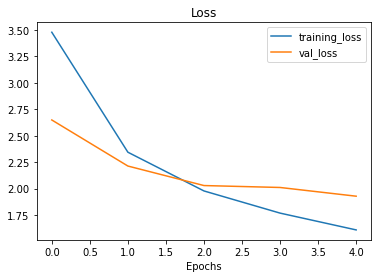

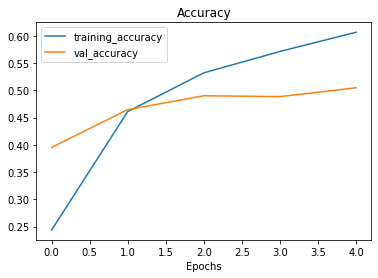

In [15]:
plot_loss_curves(history_all_classes_10_percent)

> **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not...

The curves suggest the model is overfitting to the training data.

## Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate )
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #learning rate reduced by 10x
              metrics=["accuracy"])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [19]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10   #model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                validation_steps=int(0.15 * len(test_data)),
                                                initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 81s 305ms/step - loss: 1.3652 - accuracy: 0.6539 - val_loss: 1.8776 - val_accuracy: 0.5199
Epoch 6/10
237/237 [==============================] - 70s 294ms/step - loss: 1.2270 - accuracy: 0.6791 - val_loss: 1.8669 - val_accuracy: 0.5220
Epoch 7/10
237/237 [==============================] - 69s 291ms/step - loss: 1.1476 - accuracy: 0.6943 - val_loss: 1.8892 - val_accuracy: 0.5169
Epoch 8/10
237/237 [==============================] - 65s 274ms/step - loss: 1.0805 - accuracy: 0.7158 - val_loss: 1.8763 - val_accuracy: 0.5241
Epoch 9/10
237/237 [==============================] - 66s 276ms/step - loss: 1.0115 - accuracy: 0.7337 - val_loss: 1.8761 - val_accuracy: 0.5222
Epoch 10/10
237/237 [==============================] - 61s 255ms/step - loss: 0.9711 - accuracy: 0.7435 - val_loss: 1.8793 - val_accuracy: 0.5204


In [21]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 101s 127ms/step - loss: 1.6241 - accuracy: 0.5749


[1.6241196393966675, 0.5749306678771973]

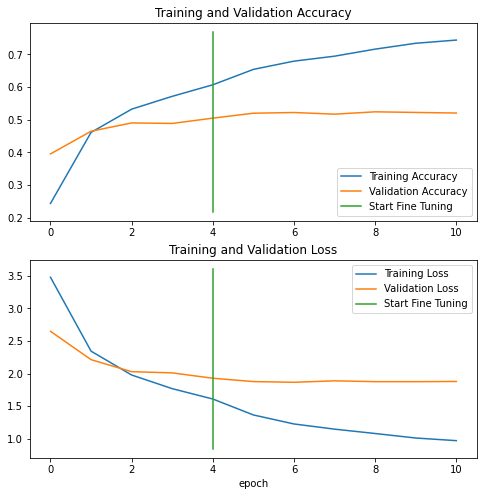

In [22]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [23]:
# Save our fine-tuning model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [24]:
#Load an evaluated saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [25]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 104s 129ms/step - loss: 1.6241 - accuracy: 0.5749


[1.6241196393966675, 0.5749306678771973]

In [26]:
#the results from our loaded_model (above) should be very similar to the results below.
all_classes_10_percent_fine_tune_results

[1.6241196393966675, 0.5749306678771973]

## Evaluating the performance of the big dog model across all diferent classes

Let's make some predictions, visualize them and then later find out which predictions were the 'most' wrong.

In [27]:
import tensorflow as tf
#download pre-trained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-08-18 19:27:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   113MB/s    in 0.4s    

2021-08-18 19:27:14 (113 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [28]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [29]:
#load in saved model
model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [30]:
# Evaluate loaded model (the one we just download on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 104s 129ms/step - loss: 1.6241 - accuracy: 0.5749


[1.6241196393966675, 0.5749306678771973]

## Making predictions with our trained model

In [31]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 88s 110ms/step


In [32]:
len(test_data)

790

In [33]:
790*32

25280

In [34]:
# How many predictions are true?
len(preds_probs)

25250

In [35]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [36]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[3.7880829e-01, 2.4900609e-04, 8.6702846e-02, ..., 6.0562717e-05,
        9.5981313e-04, 1.3922806e-01],
       [9.3805033e-01, 7.5905106e-08, 1.7739286e-03, ..., 1.3148191e-03,
        6.7127232e-08, 2.3503478e-06],
       [3.3079061e-01, 3.2499977e-03, 9.7908257e-03, ..., 8.6543569e-04,
        6.5732480e-04, 3.5390432e-03],
       ...,
       [5.1862156e-01, 2.6420939e-06, 2.4843435e-03, ..., 6.2415153e-02,
        1.6204767e-04, 6.8321133e-05],
       [9.2320733e-02, 7.3361356e-04, 6.0726441e-02, ..., 4.5108347e-04,
        1.2748037e-04, 6.3411024e-04],
       [6.8564963e-01, 1.1220875e-06, 9.9440897e-04, ..., 2.7555674e-02,
        1.7348663e-06, 2.2409791e-03]], dtype=float32)

In [37]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.78808290e-01, 2.49006087e-04, 8.67028460e-02, 5.83456874e-08,
        5.72722638e-06, 3.75766967e-06, 4.03060876e-05, 4.77318054e-06,
        5.59043400e-02, 4.65391000e-04, 7.22406810e-07, 3.37742381e-06,
        3.74354864e-03, 3.00267004e-07, 1.14250155e-02, 2.95029231e-03,
        2.59557528e-05, 6.33098884e-04, 7.96479813e-04, 2.00777868e-06,
        1.36960734e-04, 1.55143844e-05, 4.37734212e-04, 4.30147105e-04,
        5.47467440e-04, 5.47284202e-04, 2.09289166e-04, 1.17271911e-05,
        8.15128386e-02, 5.16488031e-03, 8.28670125e-07, 3.88000044e-04,
        5.58483065e-04, 4.40444296e-07, 4.78527276e-03, 4.51988080e-06,
        5.03400152e-05, 3.34248034e-04, 1.13887358e-02, 1.51769509e-05,
        1.44290796e-04, 8.41483125e-04, 3.40953266e-04, 6.37438188e-06,
        2.38933681e-05, 5.19842542e-05, 8.20468413e-04, 2.07842153e-04,
        7.69681833e-07, 2.32841559e-02, 4.91624931e-04, 2.79668438e-06,
        1.05463669e-01, 3.07367579e-03, 3.06929796e-05, 4.890443

Our model ouputs a prediction prob array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [38]:

# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.78808290e-01 2.49006087e-04 8.67028460e-02 5.83456874e-08
 5.72722638e-06 3.75766967e-06 4.03060876e-05 4.77318054e-06
 5.59043400e-02 4.65391000e-04 7.22406810e-07 3.37742381e-06
 3.74354864e-03 3.00267004e-07 1.14250155e-02 2.95029231e-03
 2.59557528e-05 6.33098884e-04 7.96479813e-04 2.00777868e-06
 1.36960734e-04 1.55143844e-05 4.37734212e-04 4.30147105e-04
 5.47467440e-04 5.47284202e-04 2.09289166e-04 1.17271911e-05
 8.15128386e-02 5.16488031e-03 8.28670125e-07 3.88000044e-04
 5.58483065e-04 4.40444296e-07 4.78527276e-03 4.51988080e-06
 5.03400152e-05 3.34248034e-04 1.13887358e-02 1.51769509e-05
 1.44290796e-04 8.41483125e-04 3.40953266e-04 6.37438188e-06
 2.38933681e-05 5.19842542e-05 8.20468413e-04 2.07842153e-04
 7.69681833e-07 2.32841559e-02 4.91624931e-04 2.79668438e-06
 1.05463669e-01 3.07367579e-03 3.06929796e-05 4.89044376e-03
 9.29150544e-03 7.03388534e-04 2.84947641e-

In [39]:
test_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [40]:
#Note: In the lecture videos, they get 52 not zero
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8, 29, 78, 29,  0,  9,  0])

In [41]:
#How many pred classes do we have?
len(pred_classes)

25250

Now we;ve got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the labels.

In [42]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [43]:
#To get our test labels we need to unrael our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [45]:
results_downloaded_model

[1.6241196393966675, 0.5749306678771973]

In [46]:
#Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

In [47]:
sklearn_accuracy

0.5749306930693069

In [48]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [49]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix

In [50]:
class_names=test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [51]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

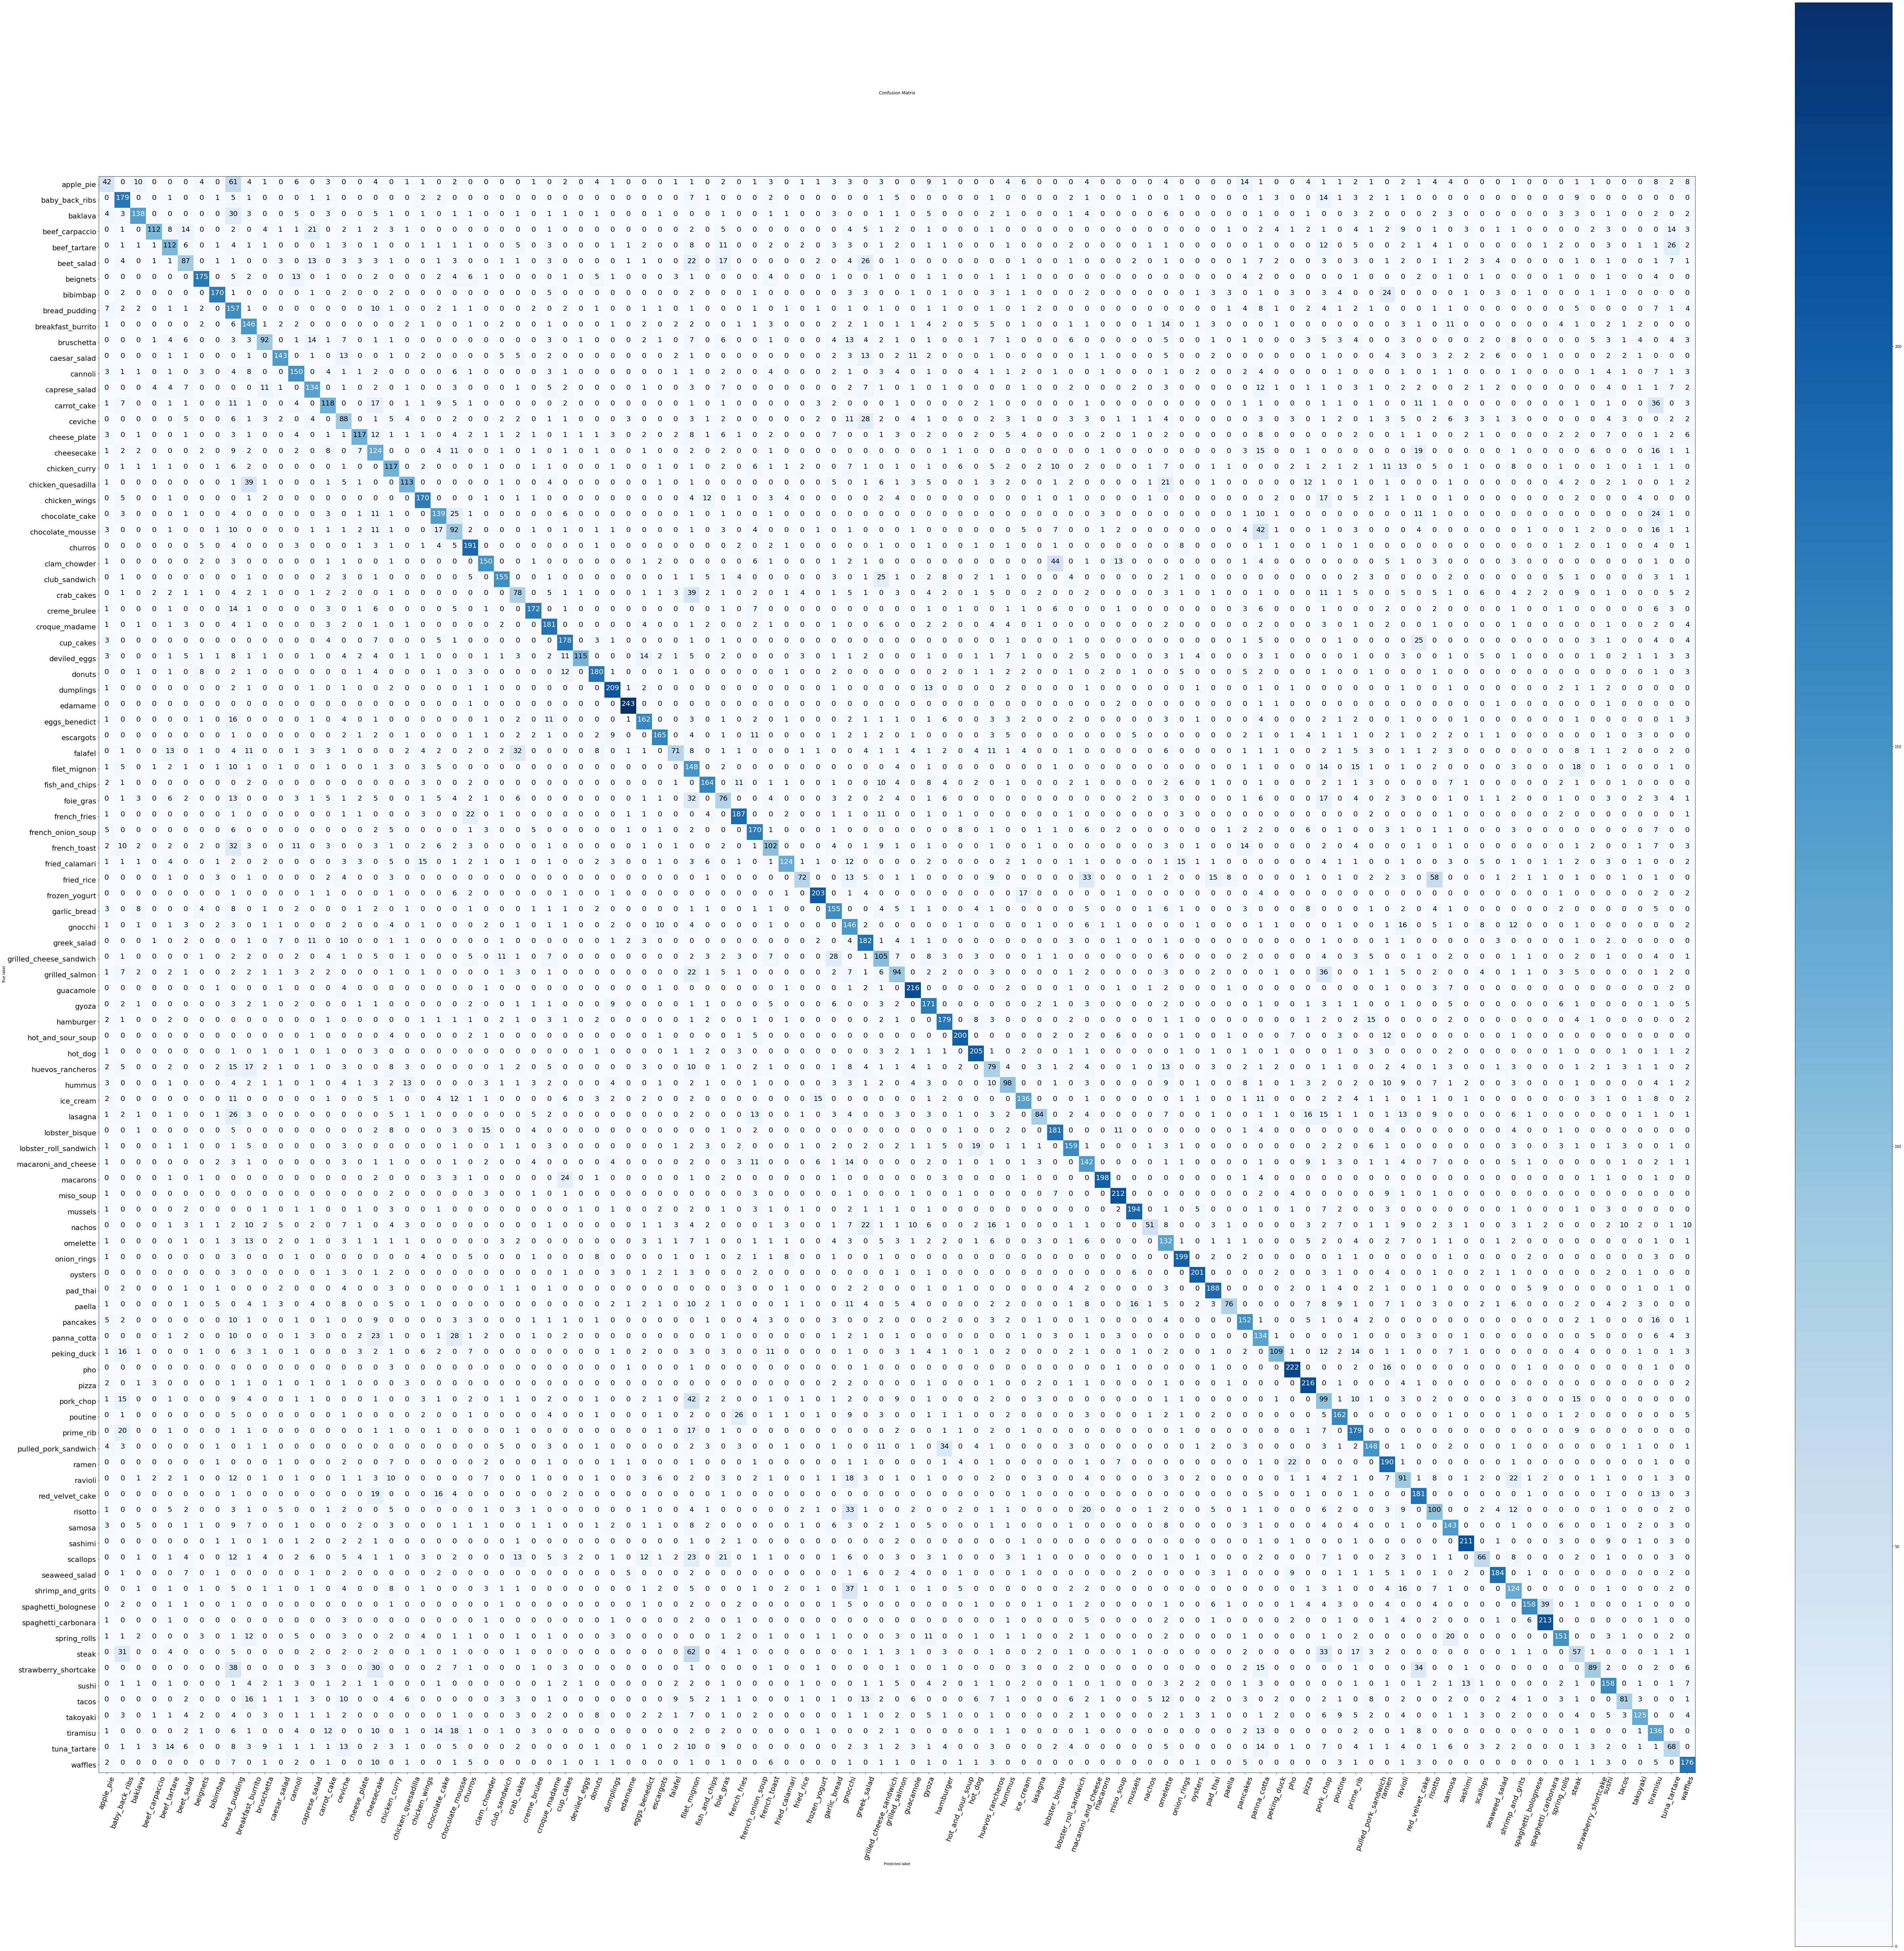

In [52]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=True)

##Let's keep the evaluation train going, time for a classification report



In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.17      0.22       250
           1       0.51      0.72      0.60       250
           2       0.72      0.55      0.62       250
           3       0.84      0.45      0.58       250
           4       0.52      0.45      0.48       250
           5       0.46      0.35      0.40       250
           6       0.78      0.70      0.74       250
           7       0.85      0.68      0.75       250
           8       0.22      0.63      0.33       250
           9       0.40      0.58      0.48       250
          10       0.59      0.37      0.45       250
          11       0.76      0.57      0.65       250
          12       0.61      0.60      0.61       250
          13       0.54      0.54      0.54       250
          14       0.57      0.47      0.52       250
          15       0.33      0.35      0.34       250
          16       0.70      0.47      0.56       250
          17       0.32    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard.

How about we create a viz to get a better understanding.

In [54]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.21875,
  'precision': 0.31343283582089554,
  'recall': 0.168,
  'support': 250},
 '1': {'f1-score': 0.5976627712854758,
  'precision': 0.5128939828080229,
  'recall': 0.716,
  'support': 250},
 '10': {'f1-score': 0.45208845208845205,
  'precision': 0.5859872611464968,
  'recall': 0.368,
  'support': 250},
 '100': {'f1-score': 0.6208112874779541,
  'precision': 0.555205047318612,
  'recall': 0.704,
  'support': 250},
 '11': {'f1-score': 0.6529680365296803,
  'precision': 0.7606382978723404,
  'recall': 0.572,
  'support': 250},
 '12': {'f1-score': 0.6072874493927126,
  'precision': 0.6147540983606558,
  'recall': 0.6,
  'support': 250},
 '13': {'f1-score': 0.5381526104417671,
  'precision': 0.5403225806451613,
  'recall': 0.536,
  'support': 250},
 '14': {'f1-score': 0.5164113785557988,
  'precision': 0.5700483091787439,
  'recall': 0.472,
  'support': 250},
 '15': {'f1-score': 0.3404255319148936,
  'precision': 0.3295880149812734,
  'recall': 0.352,
  'support': 25

In [55]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.21875,
 'baby_back_ribs': 0.5976627712854758,
 'baklava': 0.6244343891402715,
 'beef_carpaccio': 0.5848563968668408,
 'beef_tartare': 0.4796573875802998,
 'beet_salad': 0.3963553530751708,
 'beignets': 0.7368421052631577,
 'bibimbap': 0.753880266075388,
 'bread_pudding': 0.3281086729362591,
 'breakfast_burrito': 0.47790507364975454,
 'bruschetta': 0.45208845208845205,
 'caesar_salad': 0.6529680365296803,
 'cannoli': 0.6072874493927126,
 'caprese_salad': 0.5381526104417671,
 'carrot_cake': 0.5164113785557988,
 'ceviche': 0.3404255319148936,
 'cheese_plate': 0.5625,
 'cheesecake': 0.3881064162754303,
 'chicken_curry': 0.45614035087719296,
 'chicken_quesadilla': 0.5445783132530121,
 'chicken_wings': 0.688259109311741,
 'chocolate_cake': 0.5515873015873016,
 'chocolate_mousse': 0.34914611005692603,
 'churros': 0.6996336996336996,
 'clam_chowder': 0.65359477124183,
 'club_sandwich': 0.6768558951965067,
 'crab_cakes': 0.3577981651376147,
 'creme_brulee': 0.7366167023554604,
 

In [56]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.947368
63,macarons,0.857143
86,sashimi,0.838966
69,oysters,0.832298
75,pho,0.828358
...,...,...
66,nachos,0.319749
99,tuna_tartare,0.304933
77,pork_chop,0.293333
93,steak,0.256757


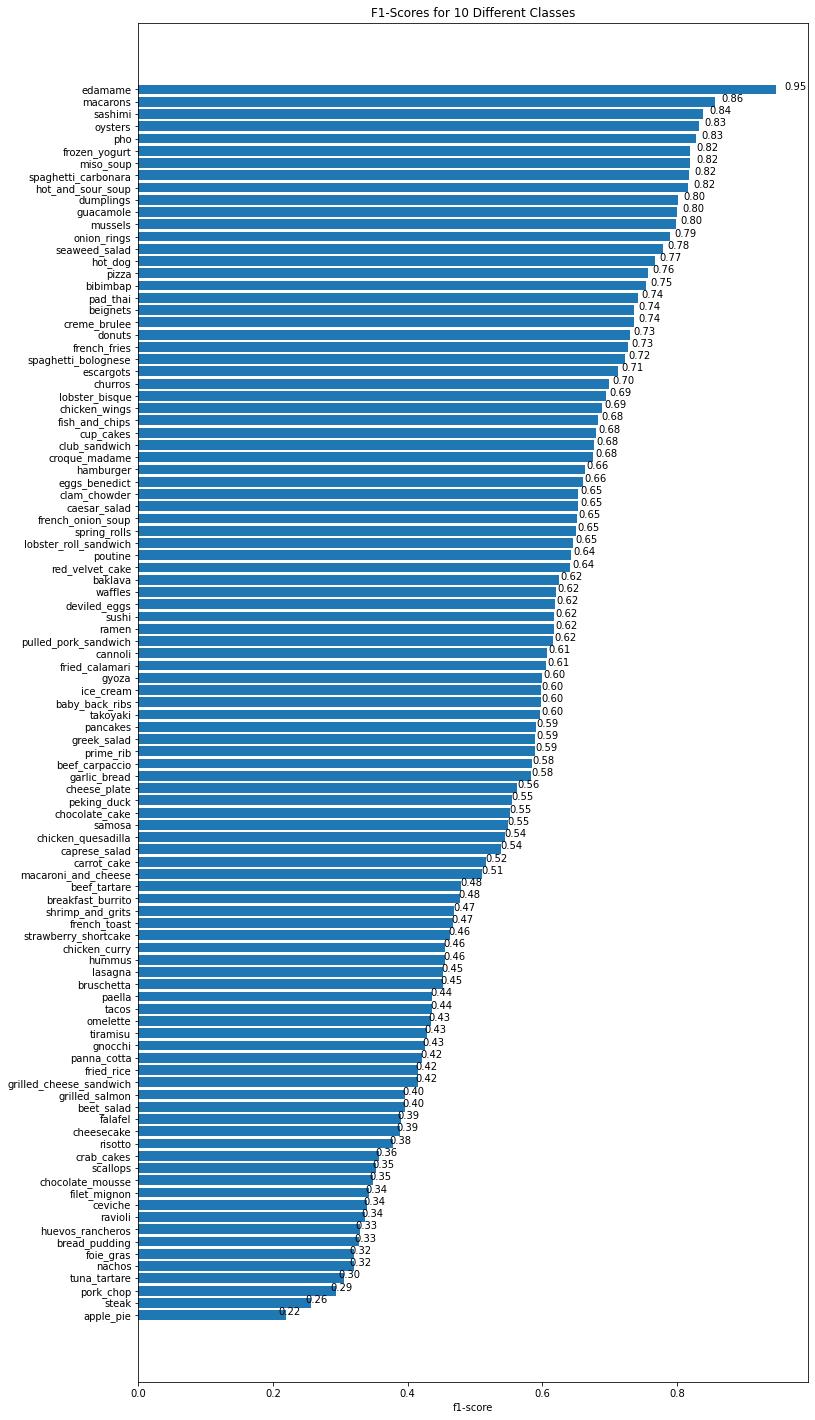

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing predictions on test images¶

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:

Read in a target image filepath using tf.io.read_file().
Turn the image into a Tensor using tf.io.decode_image().
Resize the image to be the same size as the images our model has been trained on (224 x 224) using tf.image.resize().
Scale the image to get all the pixel values between 0 & 1 if necessary.

In [72]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3)

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label.

In [73]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

NotFoundError: ignored

<Figure size 1224x720 with 0 Axes>

##Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.

2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
* **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.

3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).

4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.

5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [74]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [75]:

# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.378808,apple_pie,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.938050,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.330791,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.240213,apple_pie,bread_pudding
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,29,0.384800,apple_pie,cup_cakes


In [76]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.378808,apple_pie,apple_pie,True
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.938050,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.330791,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.240213,apple_pie,bread_pudding,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,29,0.384800,apple_pie,cup_cakes,False


In [77]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.998982,sushi,sashimi,False
23631,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.998690,strawberry_shortcake,red_velvet_cake,False
18001,b'101_food_classes_10_percent/test/pancakes/10...,72,67,0.998251,pancakes,omelette,False
10847,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.997028,fried_calamari,onion_rings,False
22203,b'101_food_classes_10_percent/test/seaweed_sal...,88,51,0.996801,seaweed_salad,guacamole,False
19521,b'101_food_classes_10_percent/test/poutine/132...,78,40,0.996459,poutine,french_fries,False
15826,b'101_food_classes_10_percent/test/macarons/19...,63,29,0.995317,macarons,cup_cakes,False
5652,b'101_food_classes_10_percent/test/chocolate_m...,22,98,0.995192,chocolate_mousse,tiramisu,False
17897,b'101_food_classes_10_percent/test/paella/2986...,71,65,0.995108,paella,mussels,False
10854,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.994014,fried_calamari,onion_rings,False


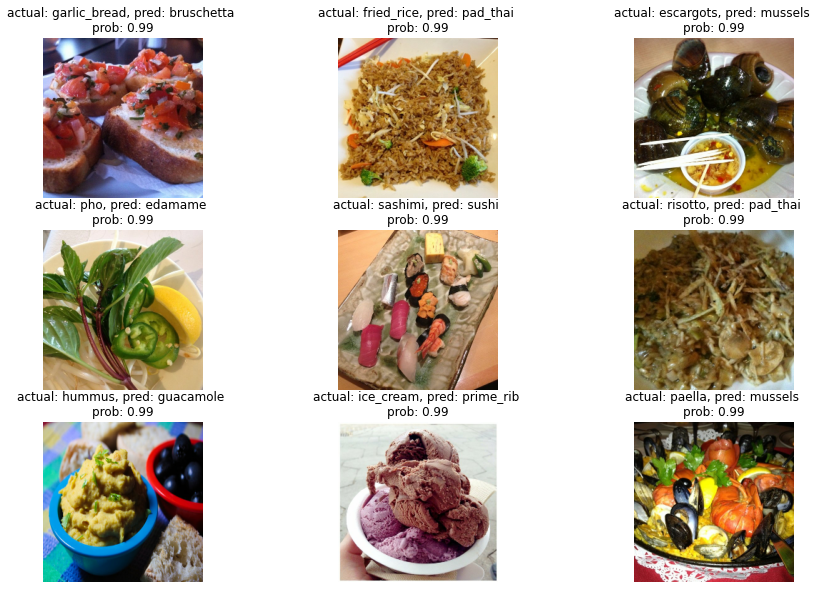

In [78]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [79]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-08-18 19:36:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  33.9MB/s    in 0.4s    

2021-08-18 19:36:13 (33.9 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [80]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg']

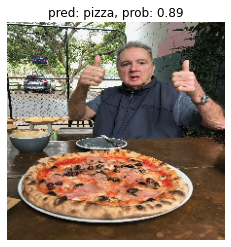

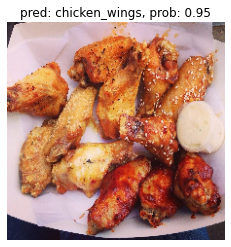

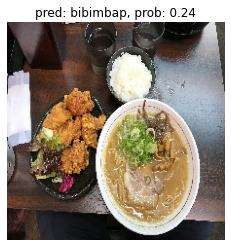

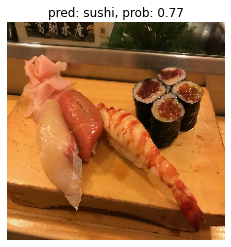

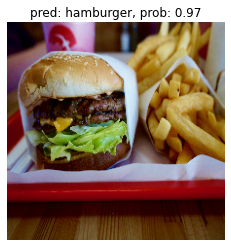

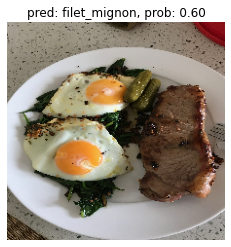

In [81]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)